In [10]:
from matplotlib import pyplot as plt
from itertools import product
# import seaborn as sns
import pandas as pd
import os.path as op
import argparse
import re
import numpy as np
import matplotlib.pyplot as plt
import mne
import seaborn as sns
from scipy import signal, stats
from scipy.fft import fftshift
from bids import BIDSLayout
from statsmodels.stats.anova import AnovaRM

from util.io.ffr import *
palette_tab10 = sns.color_palette("tab10", 10)

In [11]:
# Load accuracies
accuracies = pd.read_csv('accuracies.csv')

In [4]:
# Load ERPs
evokeds = pd.read_csv('evokeds.csv')
evokeds

,sub,chan,predictable,target,tone,accuracy,msec,uV
0,10,Cz,True,1,1,high,-173,-8.727872e-08
1,10,Cz,True,1,1,high,-172,-9.012204e-08
2,10,Cz,True,1,1,high,-171,-1.052924e-07
3,10,Cz,True,1,1,high,-170,-1.171627e-07
4,10,Cz,True,1,1,high,-169,-1.369268e-07
...,...,...,...,...,...,...,...,...
1984495,41,Pz,False,3,3,high,522,5.592560e-07
1984496,41,Pz,False,3,3,high,523,5.489198e-07
1984497,41,Pz,False,3,3,high,524,5.435890e-07
1984498,41,Pz,False,3,3,high,525,5.367600e-07


In [5]:
# Rename target and tone vars to freq
mapping = {1: 110,
           2: 150,
           3: 210}

evokeds['target'] = evokeds['target'].replace(mapping)
evokeds['tone'] = evokeds['tone'].replace(mapping)
evokeds

,sub,chan,predictable,target,tone,accuracy,msec,uV
0,10,Cz,True,110,110,high,-173,-8.727872e-08
1,10,Cz,True,110,110,high,-172,-9.012204e-08
2,10,Cz,True,110,110,high,-171,-1.052924e-07
3,10,Cz,True,110,110,high,-170,-1.171627e-07
4,10,Cz,True,110,110,high,-169,-1.369268e-07
...,...,...,...,...,...,...,...,...
1984495,41,Pz,False,210,210,high,522,5.592560e-07
1984496,41,Pz,False,210,210,high,523,5.489198e-07
1984497,41,Pz,False,210,210,high,524,5.435890e-07
1984498,41,Pz,False,210,210,high,525,5.367600e-07


In [6]:
# Adjust EEG units
evokeds['uV'] = evokeds['uV'] * 1000000 - 0.30
evokeds

,sub,chan,predictable,target,tone,accuracy,msec,uV
0,10,Cz,True,110,110,high,-173,-0.387279
1,10,Cz,True,110,110,high,-172,-0.390122
2,10,Cz,True,110,110,high,-171,-0.405292
3,10,Cz,True,110,110,high,-170,-0.417163
4,10,Cz,True,110,110,high,-169,-0.436927
...,...,...,...,...,...,...,...,...
1984495,41,Pz,False,210,210,high,522,0.259256
1984496,41,Pz,False,210,210,high,523,0.248920
1984497,41,Pz,False,210,210,high,524,0.243589
1984498,41,Pz,False,210,210,high,525,0.236760


In [7]:
# Adjust EEG timing according to lag
evokeds['msec'] = evokeds['msec'] - 27

In [8]:
# Drop subjects with fewer than 80% trials
BADS = [33, 37]
for bad in BADS:
    evokeds = evokeds[evokeds['sub'] != bad]
np.unique(evokeds['sub'])

array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 34, 35, 36, 38, 39, 40, 41])

In [10]:
# Split data up for analyses
evokeds_Cz = evokeds[evokeds.chan == 'Cz']
evokeds_tone_1 = evokeds_Cz[evokeds_Cz.tone == 110]
evokeds_tone_2 = evokeds_Cz[evokeds_Cz.tone == 150]
evokeds_tone_3 = evokeds_Cz[evokeds_Cz.tone == 210]

/scratch/local/jobs/22071381/ipykernel_1286593/339091136.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  evokeds_tone_1['target freq (Hz)'] = evokeds_tone_1.target
/scratch/local/jobs/22071381/ipykernel_1286593/339091136.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  evokeds_tone_2['target freq (Hz)'] = evokeds_tone_2.target
/scratch/local/jobs/22071381/ipykernel_1286593/339091136.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

# Tests on mean amplitudes

                  Anova
            F Value Num DF  Den DF  Pr > F
------------------------------------------
tone        10.4718 2.0000  58.0000 0.0001
target       0.4113 2.0000  58.0000 0.6647
tone:target  5.3400 4.0000 116.0000 0.0006



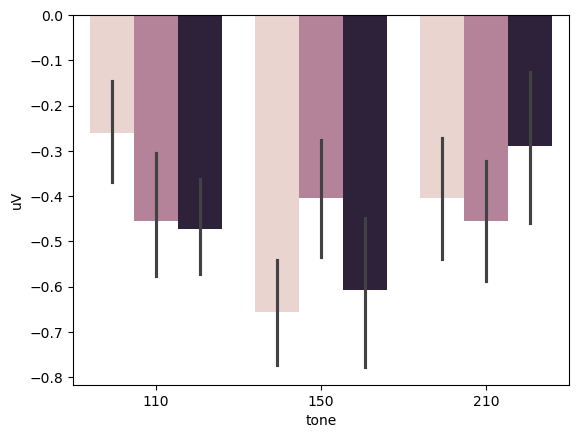

In [48]:
seg_target = evokeds_Cz[evokeds_Cz.msec > 220]
seg_target = seg_target[seg_target.msec < 420]
seg_target = seg_target.groupby(['sub', 'tone', 'target'], as_index=False)['uV'].mean()
sns.barplot(seg_target, x="tone", y="uV", hue="target", legend=False)
aov = AnovaRM(
    data = seg_target, 
    depvar = 'uV',
    subject = 'sub', 
    within = ['tone', 'target']
)
res = aov.fit()
print(res)

### Tests on peaks

#### P1 (max at 50-100 msec)

<Axes: xlabel='tone', ylabel='uV'>

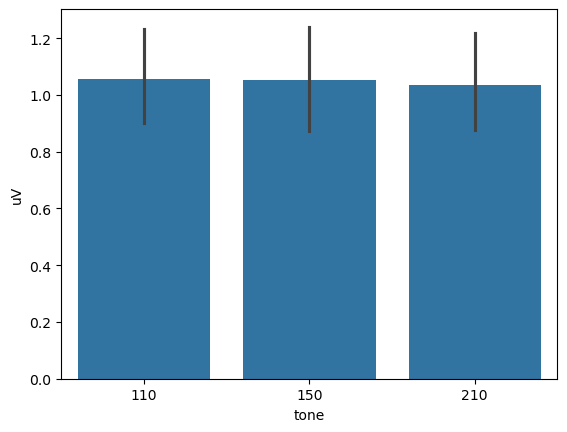

In [18]:
seg_tone = evokeds_Cz[(evokeds_Cz.msec > 50) & (evokeds_Cz.msec < 100)]
seg_tone = seg_tone.groupby(['sub', 'tone'], as_index=False)['uV'].max()
sns.barplot(seg_tone, x="tone", y="uV")

<Axes: xlabel='tone', ylabel='uV'>

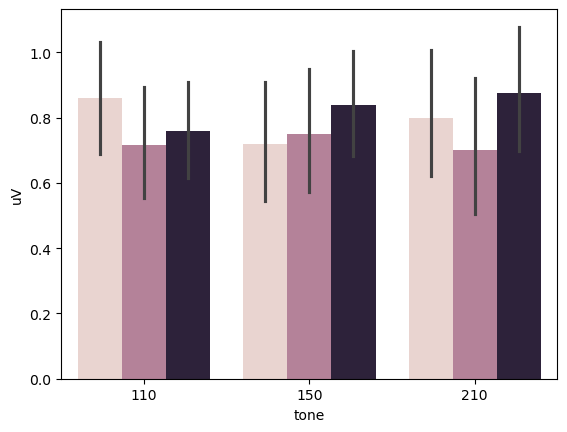

In [28]:
seg_tone = evokeds_Cz[(evokeds_Cz.msec > 50) & (evokeds_Cz.msec < 100)]
seg_tone = seg_tone.groupby(['sub', 'tone', 'target'], as_index=False)['uV'].max()
sns.barplot(seg_tone, x="tone", y="uV", hue="target", legend=False)

In [27]:
aov = AnovaRM(
    data = seg_tone, 
    depvar = 'uV',
    subject = 'sub', 
    within = ['tone', 'target']
)
res = aov.fit()
print(res)

                  Anova
            F Value Num DF  Den DF  Pr > F
------------------------------------------
tone         0.1375 2.0000  58.0000 0.8718
target       2.0861 2.0000  58.0000 0.1334
tone:target  1.6290 4.0000 116.0000 0.1716



#### Min at 70-150 msec

<Axes: xlabel='tone', ylabel='uV'>

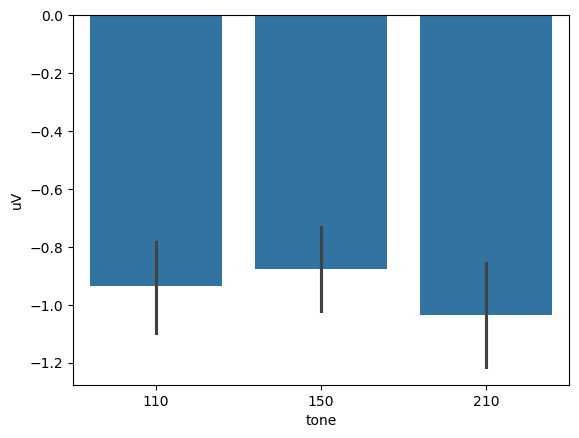

In [29]:
seg_tone = evokeds_Cz[(evokeds_Cz.msec > 70) & (evokeds_Cz.msec < 150)]
seg_tone = seg_tone.groupby(['sub', 'tone'], as_index=False)['uV'].min()
sns.barplot(seg_tone, x="tone", y="uV")

<Axes: xlabel='tone', ylabel='uV'>

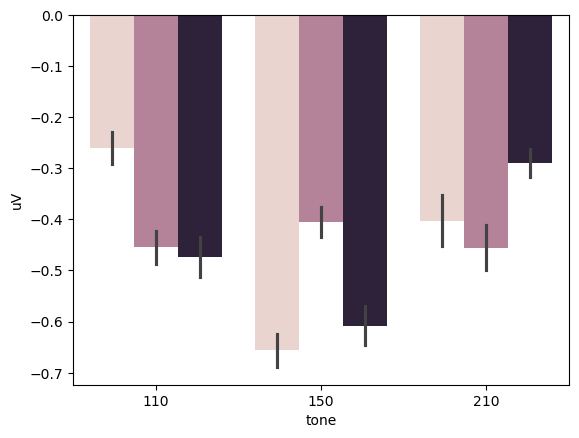

In [31]:
seg_tone = evokeds_Cz[(evokeds_Cz.msec > 70) & (evokeds_Cz.msec < 150)]
seg_tone = seg_tone.groupby(['sub', 'tone', 'target'], as_index=False)['uV'].min()
sns.barplot(seg_tone, x="tone", y="uV", hue="target", legend=False)

#### Max at 120-250 msec

In [ ]:
seg_tone = evokeds_Cz[evokeds_Cz.msec > 120]
seg_tone = seg_tone[seg_tone.msec < 250]
seg_tone = seg_tone.groupby(['sub', 'tone'], as_index=False)['uV'].max()
seg_tone
sns.barplot(seg_tone, x="tone", y="uV")

In [ ]:
seg_target = evokeds_Cz[evokeds_Cz.msec > 120]
seg_target = seg_target[seg_target.msec < 250]
seg_target = seg_target.groupby(['sub', 'tone', 'target'], as_index=False)['uV'].max()
seg_target
sns.barplot(seg_target, x="tone", y="uV", hue="target", legend=False)

#### Min at 220-420 msec

In [ ]:
seg_tone = evokeds_Cz[evokeds_Cz.msec > 220]
seg_tone = seg_tone[seg_tone.msec < 420]
seg_tone = seg_tone.groupby(['sub', 'tone'], as_index=False)['uV'].min()
seg_tone
sns.barplot(seg_tone, x="tone", y="uV")

In [ ]:
seg_target = evokeds_Cz[evokeds_Cz.msec > 220]
seg_target = seg_target[seg_target.msec < 420]
seg_target = seg_target.groupby(['sub', 'tone', 'target'], as_index=False)['uV'].min()
seg_target
sns.barplot(seg_target, x="tone", y="uV", hue="target", legend=False)

In [ ]:
aov = AnovaRM(
    data = seg_target[seg_target.tone == 150], 
    depvar = 'uV',
    subject = 'sub', 
    within = ['target']
)
res = aov.fit()
print(res)

#### Inflection point at 400 msec (Important)

In [ ]:
seg_tone = evokeds_Cz[evokeds_Cz.msec == 400]
seg_tone = seg_tone.groupby(['sub', 'tone'], as_index=False)['uV'].mean()
seg_tone
sns.barplot(seg_tone, x="tone", y="uV")
plt.tight_layout()
plt.savefig('../figs/ERP-inflection-by-tone.png')

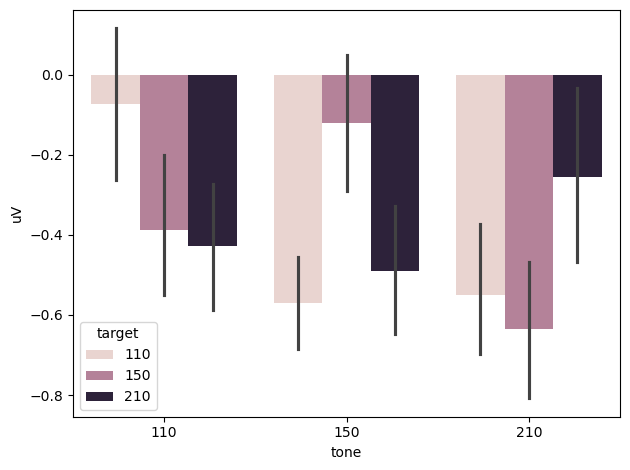

In [34]:
seg_target = evokeds_Cz[evokeds_Cz.msec == 400]
seg_target = seg_target.groupby(['sub', 'tone', 'target'], as_index=False)['uV'].mean()
seg_target
sns.barplot(seg_target, x="tone", y="uV", hue="target")
plt.tight_layout()
plt.savefig('../figs/ERP-inflection-by-target.png')

#### Tests on the inflection point

In [ ]:
# 3x3
aov = AnovaRM(
    data = seg_target, 
    depvar = 'uV',
    subject = 'sub', 
    within = ['tone', 'target']
)
res = aov.fit()
print(res)

# for tone 1
aov = AnovaRM(
    data = seg_target[seg_target.tone == 110], 
    depvar = 'uV',
    subject = 'sub', 
    within = ['target']
)
res = aov.fit()
print(res)

# for tone 2
aov = AnovaRM(
    data = seg_target[seg_target.tone == 150], 
    depvar = 'uV',
    subject = 'sub', 
    within = ['target']
)
res = aov.fit()
print(res)

# for tone 3
aov = AnovaRM(
    data = seg_target[seg_target.tone == 210], 
    depvar = 'uV',
    subject = 'sub', 
    within = ['target']
)
res = aov.fit()
print(res)

##### Factor in accuracies

In [ ]:
t = 382

# Plot
mean_evokeds = evokeds_cz[evokeds_cz.target == 110]
seg_target = mean_evokeds[mean_evokeds.msec == t]
seg_target = seg_target.groupby(['sub', 'tone', 'accuracy'], as_index=False)['uV'].mean()
sns.barplot(seg_target, x="tone", y="uV", hue="accuracy")

# Test
seg_target = evokeds_cz[(evokeds_cz.target == 110) & (evokeds_cz.tone == 110) & (evokeds_cz.msec == t)]
seg_target = seg_target.groupby(['sub', 'accuracy'], as_index=False)['uV'].mean()
print(seg_target.uV[seg_target.accuracy == 'low'].mean())
print(seg_target.uV[seg_target.accuracy == 'high'].mean())
stats.ttest_ind(seg_target.uV[seg_target.accuracy == 'low'], seg_target.uV[seg_target.accuracy == 'high'])


In [ ]:
t = 405

# Plot
mean_evokeds = evokeds_cz[evokeds_cz.target == 150]
seg_target = mean_evokeds[mean_evokeds.msec == t]
seg_target = seg_target.groupby(['sub', 'tone', 'accuracy'], as_index=False)['uV'].mean()
seg_target
sns.barplot(seg_target, x="tone", y="uV", hue="accuracy")

# Test
seg_target = evokeds_cz[(evokeds_cz.target == 150) & (evokeds_cz.tone == 150) & (evokeds_cz.msec == t)]
seg_target = seg_target.groupby(['sub', 'accuracy'], as_index=False)['uV'].mean()
print(seg_target.uV[seg_target.accuracy == 'low'].mean())
print(seg_target.uV[seg_target.accuracy == 'high'].mean())
stats.ttest_ind(seg_target.uV[seg_target.accuracy == 'low'], seg_target.uV[seg_target.accuracy == 'high'], alternative = 'less')

In [ ]:
t = 364

# Plot
mean_evokeds = evokeds_cz[evokeds_cz.target == 210]
seg_target = mean_evokeds[mean_evokeds.msec == t]
seg_target = seg_target.groupby(['sub', 'tone', 'accuracy'], as_index=False)['uV'].mean()
seg_target
sns.barplot(seg_target, x="tone", y="uV", hue="accuracy")

# Test
seg_target = evokeds_cz[(evokeds_cz.target == 210) & (evokeds_cz.tone == 210) & (evokeds_cz.msec == t)]
seg_target = seg_target.groupby(['sub', 'accuracy'], as_index=False)['uV'].mean()
print(seg_target.uV[seg_target.accuracy == 'low'].mean())
print(seg_target.uV[seg_target.accuracy == 'high'].mean())
stats.ttest_ind(seg_target.uV[seg_target.accuracy == 'low'], seg_target.uV[seg_target.accuracy == 'high'], alternative = 'less')

# Latencies

In [ ]:
mean_evokeds = evokeds[evokeds.chan == 'Cz']
mean_evokeds_tone = mean_evokeds.groupby(['chan', 'tone', 'msec'], as_index=False)['uV'].mean()
mean_evokeds_target = mean_evokeds.groupby(['chan', 'target', 'tone', 'msec'], as_index=False)['uV'].mean()
mean_evokeds_target

#### Min at 100-180 msec

In [ ]:
seg_tone = mean_evokeds_tone[mean_evokeds_tone.msec > 100]
seg_tone = seg_tone[seg_tone.msec < 180]

# # Tone 1
tmp = seg_tone[(seg_tone.tone == 110)]
lat = int(tmp.msec[tmp.uV == min(tmp.uV)])
print(f'Latency of min tone 1: {lat}')
# # Tone 2
tmp = seg_tone[(seg_tone.tone == 150)]
lat = int(tmp.msec[tmp.uV == min(tmp.uV)])
print(f'Latency of min tone 2: {lat}')
# # Tone 3
tmp = seg_tone[(seg_tone.tone == 210)]
lat = int(tmp.msec[tmp.uV == min(tmp.uV)])
print(f'Latency of min tone 3: {lat}')

seg_target = mean_evokeds_target[mean_evokeds_target.msec > 100]
seg_target = seg_target[seg_target.msec < 180]

# Tone 1 when tone 1 is target
tmp = seg_target[(seg_target.tone == 110) & (seg_target.target == 110)]
lat = int(tmp.msec[tmp.uV == min(tmp.uV)])
print(f'Latency of min tone 1, target 1: {lat}')
# Tone 1 when tone 2 is target
tmp = seg_target[(seg_target.tone == 110) & (seg_target.target == 150)]
lat = int(tmp.msec[tmp.uV == min(tmp.uV)])
print(f'Latency of min tone 1, target 2: {lat}')
# Tone 1 when tone 3 is target
tmp = seg_target[(seg_target.tone == 110) & (seg_target.target == 210)]
lat = int(tmp.msec[tmp.uV == min(tmp.uV)])
print(f'Latency of min tone 1, target 3: {lat}')

# Tone 2 when tone 1 is target
tmp = seg_target[(seg_target.tone == 150) & (seg_target.target == 110)]
lat = int(tmp.msec[tmp.uV == min(tmp.uV)])
print(f'Latency of min tone 2, target 1: {lat}')
# Tone 2 when tone 2 is target
tmp = seg_target[(seg_target.tone == 150) & (seg_target.target == 150)]
lat = int(tmp.msec[tmp.uV == min(tmp.uV)])
print(f'Latency of min tone 2, target 2: {lat}')
# Tone 2 when tone 3 is target
tmp = seg_target[(seg_target.tone == 150) & (seg_target.target == 210)]
lat = int(tmp.msec[tmp.uV == min(tmp.uV)])
print(f'Latency of min tone 2, target 3: {lat}')

# Tone 3 when tone 1 is target
tmp = seg_target[(seg_target.tone == 210) & (seg_target.target == 110)]
lat = int(tmp.msec[tmp.uV == min(tmp.uV)])
print(f'Latency of min tone 3, target 1: {lat}')
# Tone 3 when tone 2 is target
tmp = seg_target[(seg_target.tone == 210) & (seg_target.target == 150)]
lat = int(tmp.msec[tmp.uV == min(tmp.uV)])
print(f'Latency of min tone 3, target 2: {lat}')
# Tone 3 when tone 3 is target
tmp = seg_target[(seg_target.tone == 210) & (seg_target.target == 210)]
lat = int(tmp.msec[tmp.uV == min(tmp.uV)])
print(f'Latency of min tone 3, target 3: {lat}')

#### Max at 150-280 msec

In [ ]:
seg_tone = mean_evokeds_tone[mean_evokeds_tone.msec > 150]
seg_tone = seg_tone[seg_tone.msec < 280]

# # Tone 1
tmp = seg_tone[(seg_tone.tone == 110)]
lat = int(tmp.msec[tmp.uV == max(tmp.uV)])
print(f'Latency of max tone 1: {lat}')
# # Tone 2
tmp = seg_tone[(seg_tone.tone == 150)]
lat = int(tmp.msec[tmp.uV == max(tmp.uV)])
print(f'Latency of max tone 2: {lat}')
# # Tone 3
tmp = seg_tone[(seg_tone.tone == 210)]
lat = int(tmp.msec[tmp.uV == max(tmp.uV)])
print(f'Latency of max tone 3: {lat}')

seg_target = mean_evokeds_target[mean_evokeds_target.msec > 150]
seg_target = seg_target[seg_target.msec < 280]

# Tone 1 when tone 1 is target
tmp = seg_target[(seg_target.tone == 110) & (seg_target.target == 110)]
lat = int(tmp.msec[tmp.uV == max(tmp.uV)])
print(f'Latency of max tone 1, target 1: {lat}')
# Tone 1 when tone 2 is target
tmp = seg_target[(seg_target.tone == 110) & (seg_target.target == 150)]
lat = int(tmp.msec[tmp.uV == max(tmp.uV)])
print(f'Latency of max tone 1, target 2: {lat}')
# Tone 1 when tone 3 is target
tmp = seg_target[(seg_target.tone == 110) & (seg_target.target == 210)]
lat = int(tmp.msec[tmp.uV == max(tmp.uV)])
print(f'Latency of max tone 1, target 3: {lat}')

# Tone 2 when tone 1 is target
tmp = seg_target[(seg_target.tone == 150) & (seg_target.target == 110)]
lat = int(tmp.msec[tmp.uV == max(tmp.uV)])
print(f'Latency of max tone 2, target 1: {lat}')
# Tone 2 when tone 2 is target
tmp = seg_target[(seg_target.tone == 150) & (seg_target.target == 150)]
lat = int(tmp.msec[tmp.uV == max(tmp.uV)])
print(f'Latency of max tone 2, target 2: {lat}')
# Tone 2 when tone 3 is target
tmp = seg_target[(seg_target.tone == 150) & (seg_target.target == 210)]
lat = int(tmp.msec[tmp.uV == max(tmp.uV)])
print(f'Latency of max tone 2, target 3: {lat}')

# Tone 3 when tone 1 is target
tmp = seg_target[(seg_target.tone == 210) & (seg_target.target == 110)]
lat = int(tmp.msec[tmp.uV == max(tmp.uV)])
print(f'Latency of max tone 3, target 1: {lat}')
# Tone 3 when tone 2 is target
tmp = seg_target[(seg_target.tone == 210) & (seg_target.target == 150)]
lat = int(tmp.msec[tmp.uV == max(tmp.uV)])
print(f'Latency of max tone 3, target 2: {lat}')
# Tone 3 when tone 3 is target
tmp = seg_target[(seg_target.tone == 210) & (seg_target.target == 210)]
lat = int(tmp.msec[tmp.uV == max(tmp.uV)])
print(f'Latency of max tone 3, target 3: {lat}')

#### Min at 250-450 msec (important)

In [ ]:
seg_tone = mean_evokeds_tone[mean_evokeds_tone.msec > 250]
seg_tone = seg_tone[seg_tone.msec < 450]

# # Tone 1
tmp = seg_tone[(seg_tone.tone == 110)]
lat = int(tmp.msec[tmp.uV == min(tmp.uV)])
print(f'Latency of min tone 1: {lat}')
# # Tone 2
tmp = seg_tone[(seg_tone.tone == 150)]
lat = int(tmp.msec[tmp.uV == min(tmp.uV)])
print(f'Latency of min tone 2: {lat}')
# # Tone 3
tmp = seg_tone[(seg_tone.tone == 210)]
lat = int(tmp.msec[tmp.uV == min(tmp.uV)])
print(f'Latency of min tone 3: {lat}')

seg_target = mean_evokeds_target[mean_evokeds_target.msec > 250]
seg_target = seg_target[seg_target.msec < 450]

# Tone 1 when tone 1 is target
tmp = seg_target[(seg_target.tone == 110) & (seg_target.target == 110)]
lat = int(tmp.msec[tmp.uV == min(tmp.uV)])
print(f'Latency of min tone 1, target 1: {lat}')
# Tone 1 when tone 2 is target
tmp = seg_target[(seg_target.tone == 110) & (seg_target.target == 150)]
lat = int(tmp.msec[tmp.uV == min(tmp.uV)])
print(f'Latency of min tone 1, target 2: {lat}')
# Tone 1 when tone 3 is target
tmp = seg_target[(seg_target.tone == 110) & (seg_target.target == 210)]
lat = int(tmp.msec[tmp.uV == min(tmp.uV)])
print(f'Latency of min tone 1, target 3: {lat}')

# Tone 2 when tone 1 is target
tmp = seg_target[(seg_target.tone == 150) & (seg_target.target == 110)]
lat = int(tmp.msec[tmp.uV == min(tmp.uV)])
print(f'Latency of min tone 2, target 1: {lat}')
# Tone 2 when tone 2 is target
tmp = seg_target[(seg_target.tone == 150) & (seg_target.target == 150)]
lat = int(tmp.msec[tmp.uV == min(tmp.uV)])
print(f'Latency of min tone 2, target 2: {lat}')
# Tone 2 when tone 3 is target
tmp = seg_target[(seg_target.tone == 150) & (seg_target.target == 210)]
lat = int(tmp.msec[tmp.uV == min(tmp.uV)])
print(f'Latency of min tone 2, target 3: {lat}')

# Tone 3 when tone 1 is target
tmp = seg_target[(seg_target.tone == 210) & (seg_target.target == 110)]
lat = int(tmp.msec[tmp.uV == min(tmp.uV)])
print(f'Latency of min tone 3, target 1: {lat}')
# Tone 3 when tone 2 is target
tmp = seg_target[(seg_target.tone == 210) & (seg_target.target == 150)]
lat = int(tmp.msec[tmp.uV == min(tmp.uV)])
print(f'Latency of min tone 3, target 2: {lat}')
# Tone 3 when tone 3 is target
tmp = seg_target[(seg_target.tone == 210) & (seg_target.target == 210)]
lat = int(tmp.msec[tmp.uV == min(tmp.uV)])
print(f'Latency of min tone 3, target 3: {lat}')

#### Tests on latencies

In [ ]:
evokeds

In [ ]:
predictability = [True, False]

def get_latencies_tone(evokeds, start, end, peak_type):
    all_lat = []
    tones = [110, 150, 210]
    for sub in np.unique(evokeds['sub']):
        for tone in tones:
            evokeds_cz = evokeds[evokeds.chan == 'Cz']
            evokeds_sub = evokeds_cz[evokeds_cz['sub'] == sub]
            seg = evokeds_sub[evokeds_sub.msec > start]
            seg = seg[seg.msec < end]
            seg = seg[seg.tone == tone]
            if peak_type == 'min':
                peak = min(seg.uV)
            elif peak_type == 'max':
                peak = max(seg.uV)
            lat = int(seg.msec[seg.uV == peak])
            df = pd.DataFrame({
                'sub': [sub],
                'start': [start],
                'end': [end],
                'tone': [tone],
                'peak_type': [peak_type],
                'peak': [peak],
                'latency': [lat],
            })
            all_lat.append(df)
    all_lat = pd.concat(all_lat)
    return all_lat
    
def get_latencies_target(evokeds, start, end, peak_type):
    all_lat = []
    tones = [110, 150, 210]
    for sub in np.unique(evokeds['sub']):
        for tone in tones:
            for target in tones:
                evokeds_cz = evokeds[evokeds.chan == 'Cz']
                evokeds_sub = evokeds_cz[evokeds_cz['sub'] == sub]
                seg = evokeds_sub[evokeds_sub.msec > start]
                seg = seg[seg.msec < end]
                seg = seg[(seg.tone == tone) & (seg.target == target)]
                if peak_type == 'min':
                    peak = min(seg.uV)
                elif peak_type == 'max':
                    peak = max(seg.uV)
                lat = int(seg.msec[seg.uV == peak])
                df = pd.DataFrame({
                    'sub': [sub],
                    'start': [start],
                    'end': [end],
                    'tone': [tone],
                    'target': [target],
                    'peak_type': [peak_type],
                    'peak': [peak],
                    'latency': [lat],
                })
                all_lat.append(df)
    all_lat = pd.concat(all_lat)
    return all_lat

#### Min at 100-180 msec

In [ ]:
latencies_tone = get_latencies_tone(evokeds, 100, 180, 'min')
latencies_target = get_latencies_target(evokeds, 100, 180, 'min')

In [ ]:
sns.barplot(latencies_tone, x = "tone", y = "latency")

In [ ]:
sns.barplot(latencies_target, x = "tone", y = "latency", hue = "target")

#### Max at 150-280 msec

In [ ]:
latencies_tone = get_latencies_tone(evokeds, 150, 280, 'max')
latencies_target = get_latencies_target(evokeds, 150, 280, 'max')

In [ ]:
sns.barplot(latencies_tone, x = "tone", y = "latency")

In [ ]:
sns.barplot(latencies_target, x = "tone", y = "latency", hue = "target")

#### Min at 250-450 msec (important)

In [ ]:
latencies_tone = get_latencies_tone(evokeds, 250, 450, 'min')
latencies_target = get_latencies_target(evokeds, 250, 450, 'min')

In [ ]:
sns.barplot(latencies_tone, x = "tone", y = "latency")

In [ ]:
sns.barplot(latencies_target, x = "tone", y = "latency", hue = "target")

# Predictability

### Peaks

In [ ]:
mean_evokeds_predictable = mean_evokeds.groupby(['sub', 'tone', 'predictable', 'msec'], as_index=False)['uV'].mean()

#### Max at 80-130 msec

In [ ]:
seg = mean_evokeds_predictable[mean_evokeds_predictable.msec > 80]
seg = seg[seg.msec < 130]

# Tone 1
seg_1 = seg[seg.tone == 110]
print(f'Max for predictable tone 1: {max(seg_1.uV[seg_1.predictable == True])}')
print(f'Max for unpredictable tone 1: {max(seg_1.uV[seg_1.predictable == False])}')

# Tone 2
seg_2 = seg[seg.tone == 150]
print(f'Max for predictable tone 2: {max(seg_2.uV[seg_2.predictable == True])}')
print(f'Max for unpredictable tone 2: {max(seg_2.uV[seg_2.predictable == False])}')

# Tone 3
seg_3 = seg[seg.tone == 210]
print(f'Max for predictable tone 3: {max(seg_3.uV[seg_3.predictable == True])}')
print(f'Max for unpredictable tone 3: {max(seg_3.uV[seg_3.predictable == False])}')

# Plot
seg = seg.groupby(['sub', 'tone', 'predictable'], as_index = False)['uV'].max()
sns.barplot(seg, x = "tone", y = "uV", hue = "predictable")

# Test
aov = AnovaRM(
    data = seg, 
    depvar = 'uV',
    subject = 'sub', 
    within = ['predictable', 'tone']
)
res = aov.fit()
print(res)

#### Min at 100-180 msec

In [ ]:
seg = mean_evokeds_predictable[mean_evokeds_predictable.msec > 100]
seg = seg[seg.msec < 180]

# Tone 1
seg_1 = seg[seg.tone == 110]
print(f'Max for predictable tone 1: {max(seg_1.uV[seg_1.predictable == True])}')
print(f'Max for unpredictable tone 1: {max(seg_1.uV[seg_1.predictable == False])}')

# Tone 2
seg_2 = seg[seg.tone == 150]
print(f'Max for predictable tone 2: {max(seg_2.uV[seg_2.predictable == True])}')
print(f'Max for unpredictable tone 2: {max(seg_2.uV[seg_2.predictable == False])}')

# Tone 3
seg_3 = seg[seg.tone == 210]
print(f'Max for predictable tone 3: {max(seg_3.uV[seg_3.predictable == True])}')
print(f'Max for unpredictable tone 3: {max(seg_3.uV[seg_3.predictable == False])}')

# Plot
seg = seg.groupby(['sub', 'tone', 'predictable'], as_index = False)['uV'].max()
sns.barplot(seg, x = "tone", y = "uV", hue = "predictable")

# Test
aov = AnovaRM(
    data = seg, 
    depvar = 'uV',
    subject = 'sub', 
    within = ['predictable', 'tone']
)
res = aov.fit()
print(res)

#### Max at 150-280 msec

In [ ]:
seg = mean_evokeds_predictable[mean_evokeds_predictable.msec > 150]
seg = seg[seg.msec < 280]

# Tone 1
seg_1 = seg[seg.tone == 110]
print(f'Max for predictable tone 1: {max(seg_1.uV[seg_1.predictable == True])}')
print(f'Max for unpredictable tone 1: {max(seg_1.uV[seg_1.predictable == False])}')

# Tone 2
seg_2 = seg[seg.tone == 150]
print(f'Max for predictable tone 2: {max(seg_2.uV[seg_2.predictable == True])}')
print(f'Max for unpredictable tone 2: {max(seg_2.uV[seg_2.predictable == False])}')

# Tone 3
seg_3 = seg[seg.tone == 210]
print(f'Max for predictable tone 3: {max(seg_3.uV[seg_3.predictable == True])}')
print(f'Max for unpredictable tone 3: {max(seg_3.uV[seg_3.predictable == False])}')

# Plot
seg = seg.groupby(['sub', 'tone', 'predictable'], as_index = False)['uV'].max()
sns.barplot(seg, x = "tone", y = "uV", hue = "predictable")

# Test
aov = AnovaRM(
    data = seg, 
    depvar = 'uV',
    subject = 'sub', 
    within = ['predictable', 'tone']
)
res = aov.fit()
print(res)

#### Min at 250-450 msec

In [ ]:
seg = mean_evokeds_predictable[mean_evokeds_predictable.msec > 250]
seg = seg[seg.msec < 450]

# Tone 1
seg_1 = seg[seg.tone == 110]
print(f'Max for predictable tone 1: {max(seg_1.uV[seg_1.predictable == True])}')
print(f'Max for unpredictable tone 1: {max(seg_1.uV[seg_1.predictable == False])}')

# Tone 2
seg_2 = seg[seg.tone == 150]
print(f'Max for predictable tone 2: {max(seg_2.uV[seg_2.predictable == True])}')
print(f'Max for unpredictable tone 2: {max(seg_2.uV[seg_2.predictable == False])}')

# Tone 3
seg_3 = seg[seg.tone == 210]
print(f'Max for predictable tone 3: {max(seg_3.uV[seg_3.predictable == True])}')
print(f'Max for unpredictable tone 3: {max(seg_3.uV[seg_3.predictable == False])}')

# Plot
seg = seg.groupby(['sub', 'tone', 'predictable'], as_index = False)['uV'].max()
sns.barplot(seg, x = "tone", y = "uV", hue = "predictable")

# Test
aov = AnovaRM(
    data = seg, 
    depvar = 'uV',
    subject = 'sub', 
    within = ['predictable', 'tone']
)
res = aov.fit()
print(res)

# Peak values

In [17]:
mean_evokeds_tone = evokeds_Cz.groupby(['tone', 'msec'], as_index=False)['uV'].mean()
mean_evokeds_target = mean_evokeds.groupby(['target', 'tone', 'msec'], as_index=False)['uV'].mean()
mean_evokeds_predictable = mean_evokeds.groupby(['tone', 'predictable', 'msec'], as_index=False)['uV'].mean()
mean_evokeds_predictable

,tone,predictable,msec,uV
0,110,False,-200,-0.626845
1,110,False,-199,-0.625476
2,110,False,-198,-0.631240
3,110,False,-197,-0.631118
4,110,False,-196,-0.636858
...,...,...,...,...
4195,210,True,495,0.087812
4196,210,True,496,0.086111
4197,210,True,497,0.090669
4198,210,True,498,0.088699


#### P1 (max at 50-100 msec)

In [ ]:
seg_tone = mean_evokeds_tone[mean_evokeds_tone.msec > 50]
seg_tone = seg_tone[seg_tone.msec < 100]

# Tone 1
print(f'Max tone 1: {max(seg_tone.uV[seg_tone.tone == 110])}')
# Tone 2
print(f'Max tone 2: {max(seg_tone.uV[seg_tone.tone == 150])}')
# Tone 3
print(f'Max tone 3: {max(seg_tone.uV[seg_tone.tone == 210])}')

seg_target = mean_evokeds_target[mean_evokeds_target.msec > 50]
seg_target = seg_target[seg_target.msec < 100]

# Tone 1 when tone 1 is target
print(f'Max tone 1, target 1: {max(seg_target.uV[(seg_target.tone == 110) & (seg_target.target == 110)])}')
# Tone 1 when tone 2 is target
print(f'Max tone 1, target 2: {max(seg_target.uV[(seg_target.tone == 110) & (seg_target.target == 150)])}')
# Tone 1 when tone 3 is target
print(f'Max tone 1, target 3: {max(seg_target.uV[(seg_target.tone == 110) & (seg_target.target == 210)])}')
# Tone 2 when tone 1 is target
print(f'Max tone 2, target 1: {max(seg_target.uV[(seg_target.tone == 150) & (seg_target.target == 110)])}')
# Tone 2 when tone 2 is target
print(f'Max tone 2, target 2: {max(seg_target.uV[(seg_target.tone == 150) & (seg_target.target == 150)])}')
# Tone 2 when tone 3 is target
print(f'Max tone 3, target 3: {max(seg_target.uV[(seg_target.tone == 150) & (seg_target.target == 210)])}')
# Tone 3 when tone 1 is target
print(f'Max tone 3, target 1: {max(seg_target.uV[(seg_target.tone == 210) & (seg_target.target == 110)])}')
# Tone 3 when tone 2 is target
print(f'Max tone 3, target 2: {max(seg_target.uV[(seg_target.tone == 210) & (seg_target.target == 150)])}')
# Tone 3 when tone 3 is target
print(f'Max tone 3, target 3: {max(seg_target.uV[(seg_target.tone == 210) & (seg_target.target == 210)])}')

#### N1 (min at 70-150 msec)

In [ ]:
seg_tone = mean_evokeds_tone[mean_evokeds_tone.msec > 70]
seg_tone = seg_tone[seg_tone.msec < 150]

# Tone 1
print(f'Max tone 1: {min(seg_tone.uV[seg_tone.tone == 110])}')
# Tone 2
print(f'Max tone 2: {min(seg_tone.uV[seg_tone.tone == 150])}')
# Tone 3
print(f'Max tone 3: {min(seg_tone.uV[seg_tone.tone == 210])}')

seg_target = mean_evokeds_target[mean_evokeds_target.msec > 70]
seg_target = seg_target[seg_target.msec < 150]

# Tone 1 when tone 1 is target
print(f'Max tone 1, target 1: {min(seg_target.uV[(seg_target.tone == 110) & (seg_target.target == 110)])}')
# Tone 1 when tone 2 is target
print(f'Max tone 1, target 2: {min(seg_target.uV[(seg_target.tone == 110) & (seg_target.target == 150)])}')
# Tone 1 when tone 3 is target
print(f'Max tone 1, target 3: {min(seg_target.uV[(seg_target.tone == 110) & (seg_target.target == 210)])}')
# Tone 2 when tone 1 is target
print(f'Max tone 2, target 1: {min(seg_target.uV[(seg_target.tone == 150) & (seg_target.target == 110)])}')
# Tone 2 when tone 2 is target
print(f'Max tone 2, target 2: {min(seg_target.uV[(seg_target.tone == 150) & (seg_target.target == 150)])}')
# Tone 2 when tone 3 is target
print(f'Max tone 3, target 3: {min(seg_target.uV[(seg_target.tone == 150) & (seg_target.target == 210)])}')
# Tone 3 when tone 1 is target
print(f'Max tone 3, target 1: {min(seg_target.uV[(seg_target.tone == 210) & (seg_target.target == 110)])}')
# Tone 3 when tone 2 is target
print(f'Max tone 3, target 2: {min(seg_target.uV[(seg_target.tone == 210) & (seg_target.target == 150)])}')
# Tone 3 when tone 3 is target
print(f'Max tone 3, target 3: {min(seg_target.uV[(seg_target.tone == 210) & (seg_target.target == 210)])}')

#### P2 (max at 120-250 msec)

In [ ]:
seg_tone = mean_evokeds_tone[mean_evokeds_tone.msec > 120]
seg_tone = seg_tone[seg_tone.msec < 250]

# Tone 1
print(f'Max tone 1: {max(seg_tone.uV[seg_tone.tone == 110])}')
# Tone 2
print(f'Max tone 2: {max(seg_tone.uV[seg_tone.tone == 150])}')
# Tone 3
print(f'Max tone 3: {max(seg_tone.uV[seg_tone.tone == 210])}')

seg_target = mean_evokeds_target[mean_evokeds_target.msec > 120]
seg_target = seg_target[seg_target.msec < 250]

# Tone 1 when tone 1 is target
print(f'Max tone 1, target 1: {max(seg_target.uV[(seg_target.tone == 110) & (seg_target.target == 110)])}')
# Tone 1 when tone 2 is target
print(f'Max tone 1, target 2: {max(seg_target.uV[(seg_target.tone == 110) & (seg_target.target == 150)])}')
# Tone 1 when tone 3 is target
print(f'Max tone 1, target 3: {max(seg_target.uV[(seg_target.tone == 110) & (seg_target.target == 210)])}')
# Tone 2 when tone 1 is target
print(f'Max tone 2, target 1: {max(seg_target.uV[(seg_target.tone == 150) & (seg_target.target == 110)])}')
# Tone 2 when tone 2 is target
print(f'Max tone 2, target 2: {max(seg_target.uV[(seg_target.tone == 150) & (seg_target.target == 150)])}')
# Tone 2 when tone 3 is target
print(f'Max tone 3, target 3: {max(seg_target.uV[(seg_target.tone == 150) & (seg_target.target == 210)])}')
# Tone 3 when tone 1 is target
print(f'Max tone 3, target 1: {max(seg_target.uV[(seg_target.tone == 210) & (seg_target.target == 110)])}')
# Tone 3 when tone 2 is target
print(f'Max tone 3, target 2: {max(seg_target.uV[(seg_target.tone == 210) & (seg_target.target == 150)])}')
# Tone 3 when tone 3 is target
print(f'Max tone 3, target 3: {max(seg_target.uV[(seg_target.tone == 210) & (seg_target.target == 210)])}')

#### N2 (min at 220-420 msec)

In [ ]:
seg_tone = mean_evokeds_tone[mean_evokeds_tone.msec > 220]
seg_tone = seg_tone[seg_tone.msec < 420]

# Tone 1
print(f'Max tone 1: {min(seg_tone.uV[seg_tone.tone == 110])}')
# Tone 2
print(f'Max tone 2: {min(seg_tone.uV[seg_tone.tone == 150])}')
# Tone 3
print(f'Max tone 3: {min(seg_tone.uV[seg_tone.tone == 210])}')

seg_target = mean_evokeds_target[mean_evokeds_target.msec > 220]
seg_target = seg_target[seg_target.msec < 420]

# Tone 1 when tone 1 is target
print(f'Max tone 1, target 1: {min(seg_target.uV[(seg_target.tone == 110) & (seg_target.target == 110)])}')
# Tone 1 when tone 2 is target
print(f'Max tone 1, target 2: {min(seg_target.uV[(seg_target.tone == 110) & (seg_target.target == 150)])}')
# Tone 1 when tone 3 is target
print(f'Max tone 1, target 3: {min(seg_target.uV[(seg_target.tone == 110) & (seg_target.target == 210)])}')
# Tone 2 when tone 1 is target
print(f'Max tone 2, target 1: {min(seg_target.uV[(seg_target.tone == 150) & (seg_target.target == 110)])}')
# Tone 2 when tone 2 is target
print(f'Max tone 2, target 2: {min(seg_target.uV[(seg_target.tone == 150) & (seg_target.target == 150)])}')
# Tone 2 when tone 3 is target
print(f'Max tone 3, target 3: {min(seg_target.uV[(seg_target.tone == 150) & (seg_target.target == 210)])}')
# Tone 3 when tone 1 is target
print(f'Max tone 3, target 1: {min(seg_target.uV[(seg_target.tone == 210) & (seg_target.target == 110)])}')
# Tone 3 when tone 2 is target
print(f'Max tone 3, target 2: {min(seg_target.uV[(seg_target.tone == 210) & (seg_target.target == 150)])}')
# Tone 3 when tone 3 is target
print(f'Max tone 3, target 3: {min(seg_target.uV[(seg_target.tone == 210) & (seg_target.target == 210)])}')